In [233]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


In [234]:
# Usage in illustrator

import matplotlib.pyplot


plt.rc('font', family='arial')
#matplotlib.use('cairo')
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['xtick.major.pad']= 2
matplotlib.rcParams['ytick.major.pad']= 2
matplotlib.rcParams['axes.labelpad']= 4 
matplotlib.rcParams['axes.labelweight']= 'bold' 
matplotlib.rcParams['axes.labelsize']= 6

matplotlib.pyplot.rcParams.update({
    "pgf.preamble": "\\usepackage{arev}\n \\usepackage[T1]{fontenc}"
})

In [ ]:
nominal_sizes = pd.read_excel(
    './beamshaping_knife-edge_FIB_values.xlsx',
    sheet_name='Sheet1',
    header=2,
    usecols=[4, 1]
)
nominal_sizes


,Nominal Probe (nm),Measured Current
0,7,1.57
1,13,10.13
2,17,32.00
3,19,51.00
4,24,102.00
5,31,298.00
6,35,494.00
7,44,1060.00
8,66,3140.00
9,85,5260.00


In [236]:
def import_all_csv_from_folder(folder_path, delimiter=';', decimal='.', header=2, names=['x', 'y']):
    """
    Imports all CSV files from the specified folder and returns a dict
    with filenames (without extension) as keys and DataFrames as values.
    """
    csv_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')]
    dataframes = {}
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, delimiter=delimiter, decimal=decimal,
                         header=header, names=names, index_col=False)
        key = os.path.splitext(file)[0]
        dataframes[key] = df
    return dataframes

In [237]:
def process_curve(df, name):
    """
    Processes a single curve DataFrame:
    - Normalizes y
    - Aligns x at y=0.5
    - Computes 10/90 and 20/80 edge widths
    - Extracts beam current from filename

    Returns a tuple of:
    - result dict with metrics
    - DataFrame of aligned curve data (x_shifted, y_norm, series)
    """
    x = df['x'].values
    y = df['y'].values

    # Normalize
    n = len(y)
    k = max(3, n // 10)
    left_plateau  = y[:k]
    right_plateau = y[-k:]

    # 3) Robust centering
    y_min = np.median(left_plateau)
    y_max = np.median(right_plateau)
    y_norm = (y - y_min) / (y_max - y_min)
    if y_norm[0] > y_norm[-1]:
        y_norm = -y_norm + 1

    # Align at half-maximum
    x_half = np.interp(0.5, y_norm, x)
    x_shifted = x - x_half

    # Compute edge widths
    x01 = np.interp(0.1, y_norm, x)
    x09 = np.interp(0.9, y_norm, x)
    x02 = np.interp(0.2, y_norm, x)
    x08 = np.interp(0.8, y_norm, x)
    x025 = np.interp(0.25, y_norm, x)
    x075 = np.interp(0.75, y_norm, x)
    dx_90_10 = (x09 - x01) * 1e9
    dx_80_20 = (x08 - x02) * 1e9
    d50 = 1.76 * (x075 - x025) * 1e9 #https://doi.org/10.1116/1.5048054 and https://doi.org/10.1116/1.2907780

    # Parse current from name
    match = re.search(r"([\d.]+)\s*pA", name)
    current = float(match.group(1)) if match else np.nan

    result = {
        'name': name,
        'current_pA': current,
        'dx_90_10': dx_90_10,
        'dx_80_20': dx_80_20,
        'd50': d50
    }
    curve_df = pd.DataFrame({
        'x_shifted': x_shifted * 1e9,
        'y_norm': y_norm,        
        'current_pA': current,
        'name': name
    })
    return result, curve_df

In [238]:
def process_all(folder_path):
    """
    Imports and processes all CSV files in a folder.
    Returns:
    - results_df: DataFrame of metrics for each series
    - curves_df: DataFrame of aligned curves concatenated
    """
    data_dict = import_all_csv_from_folder(folder_path)
    results = []
    curve_list = []
    for name, df in data_dict.items():
        res, curve_df = process_curve(df, name)
        results.append(res)
        curve_list.append(curve_df)

    results_df = pd.DataFrame(results)
    curves_df = pd.concat(curve_list, ignore_index=True)
    results_df.sort_values('current_pA', inplace=True)
    return data_dict, results_df, curves_df

In [239]:
def plot_raw_curves(data_dict, figsize=(8, 5)):
    """
    Plots raw x vs y curves for each series.
    """
    fig, ax = plt.subplots(figsize=figsize)
    for name, df in data_dict.items():
        ax.plot(df['x'], df['y'], label=name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Raw Knife-Edge Curves')
    ax.legend()
    plt.tight_layout()
    plt.show()


In [240]:
def plot_curves(curves_df,dataset='', xlim=(-300, 300), ylim=(0.1, 0.9), figsize=(8,5)):
    """
    Plots aligned, normalized curves for each series.
    """
    fig, ax = plt.subplots(figsize=figsize)
    for name, group in curves_df.groupby('name'):
        ax.plot(group['x_shifted'], group['y_norm'], label=name)
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.axhline(0.5, linestyle='--', linewidth=1)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('x (aligned at y=0.5) (nm)')
    ax.set_ylabel('normalized y')
    ax.set_title('Aligned and Normalized Curves ' + dataset)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [241]:
def fit_wendepunkt(curves_df, window=0.25):
    """
    Fits a line y = m*x + t around the inflection region (y≈0.5) for each series,
    using points where y_norm is within ±window of 0.5.
    Calculates the 20–80% width from the fitted line.

    Returns a DataFrame with columns:
    ['name', 'current_pA', 'slope', 'intercept', 'dx_fit_80_20']
    """
    fit_results = []
    for series, grp in curves_df.groupby('name'):
        x = grp['x_shifted'].values
        y = grp['y_norm'].values
        mask = (y >= 0.5 - window) & (y <= 0.5 + window)
        x_w, y_w = x[mask], y[mask]
        if len(x_w) < 2:
            continue
        m, t = np.polyfit(x_w, y_w, 1)
        x20 = (0.2 - t) / m
        x80 = (0.8 - t) / m
        x25 = (0.25 - t) / m
        x75 = (0.75 - t) / m
        dx = x80 - x20
        d50 = (x75 - x25) * 1.76
        fit_results.append({
            'name': series,
            'current_pA': grp['current_pA'].iloc[0],            
            'slope': m,
            'intercept': t,
            'dx_fit_80_20': dx,
            'd50_fit': d50
        })
    return pd.DataFrame(fit_results)

In [242]:
def plot_fitted_results(fit_df,nominal_sizes=None, figsize=(4, 3)):
    """
    Plots beam current vs. fitted 20/80 width on a semilogx scale,
    coloring points by the 'dataset' column in combined_metrics_df if provided.
    """

    fig, ax = plt.subplots(figsize=figsize)
    if 'dataset' in fit_df:
        for ds, grp in fit_df.groupby('dataset'):
            if ds == 'roundProbe':
                color = 'k'
            else:
                color = 'r'
            ax.semilogx(
                grp['current_pA'],
                #grp['dx_fit_80_20'],
                grp['d50_fit'],
                marker='o', linestyle='', markersize=4, color=color,
                label=str(ds)
            )
    else:
        ax.semilogx(
            fit_df['current_pA'],
            #fit_df['dx_fit_80_20'],
            fit_df['d50_fit'],
            marker='o', linestyle='', markersize=4
        )

    if nominal_sizes is not None:
        ax.semilogx(nominal_sizes['Measured Current'], nominal_sizes['Nominal Probe (nm)'], 'k-', label='Nominal Probe')
    

    
    ax.set_xlabel('Beam current (pA)')
    ax.set_ylabel('Fitted 20/80 width')
    ax.set_title('Fitted Knife-edge Width vs. Current')
    if 'dataset' in fit_df:
        ax.legend(title='Dataset', fontsize='small', title_fontsize='small')
    plt.tight_layout()
    plt.show()

In [243]:
def plot_fit_lines(curves_df, fit_df, xlim=(-300, 300), ylim=(0, 1), figsize=(8,5)):
    """
    Plots each aligned, normalized curve and overlays its linear fit 
    (y = m*x + t) around the y≈0.5 region.

    Parameters
    ----------
    curves_df : DataFrame
        Must contain columns ['x_shifted', 'y_norm', 'name'].
    fit_df : DataFrame
        Must contain columns ['name', 'slope', 'intercept'].
    xlim : tuple
        (xmin, xmax) in nm for the fit‐line span.
    ylim : tuple
        (ymin, ymax) for the normalized curves.
    figsize : tuple
        Figure size.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    for name, grp in curves_df.groupby('name'):
        ax.plot(grp['x_shifted'], grp['y_norm'],linewidth=1, label=f"{name} data", alpha=1)

    # Overlay fit lines
    x_vals = np.linspace(xlim[0], xlim[1], 200)
    i = 0
    for _, row in fit_df.iterrows():
        if i == 0:
            dataset = row['dataset']
        m, t, nm = row['slope'], row['intercept'], row['name']
        y_fit = m * x_vals + t
        ax.plot(x_vals, y_fit, '--',
                label=f"{nm} fit (m={m:.3e})", 
                linewidth=0.5, color='gray')
        


    #ax.axvline(0, linestyle='--', color='gray', linewidth=1)
    #ax.axhline(0.5, linestyle='--', color='gray', linewidth=1)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('Length (nm)', fontsize=6)
    ax.set_ylabel('Intensity (a.u.)', fontsize=6)
    #ax.set_title('Aligned Curves with Linear Fits at y≈0.5 for ' + dataset )
    #ax.legend(fontsize='small', ncol=2)
    fig.tight_layout()
    fig.savefig('beamshaping_knife-edge_raw_data_fit_'+ dataset +'.png',dpi=600, transparent=True)
    fig.savefig('beamshaping_knife-edge_raw_data_fit_'+ dataset +'.pdf',dpi=600, bbox_inches='tight',transparent=True)
    return fig,ax


In [244]:
def plot_results(results_df,nominal_sizes=None, figsize=(3,2), scale='semilogx', plot_function = 'd50'):
    fig, ax = plt.subplots(figsize=figsize)
    
    if nominal_sizes is not None:        
        if scale == 'semilogx':
            ax.semilogx(nominal_sizes['Measured Current']/1000,
                        nominal_sizes['Nominal Probe (nm)'],
                        '-',
                        color = 'grey',
                        linewidth=1.5,
                        label='nominal')
        elif scale == 'loglog':   
            ax.loglog(
                nominal_sizes['Measured Current']/1000,
                nominal_sizes['Nominal Probe (nm)'],
                '-',
                color = 'grey',
                linewidth=1.5,
                label='nominal')

    alpha = 0.7
    # Loop over each dataset and plot with its own color/label
    for dataset_name, grp in results_df.groupby('dataset'):
        if dataset_name == 'roundProbe':
            color = '#cf782c'
            label = 'round'
        else:
            color = 'r'
            label = 'shaped'
        if plot_function == 'd50':
            y_data = grp['d50']
        elif plot_function == 'dx_80_20':
            y_data = grp['dx_80_20']
        
        if scale == 'semilogx':
            ax.semilogx(
                grp['current_pA']/1000, 
                y_data,
                marker='o', 
                linestyle='-',
                linewidth=1.5,
                color=color,
                markeredgewidth=0.,
                alpha=alpha,
                markersize=4, 
                label=label
            )
        elif scale == 'loglog':
            ax.loglog(
                grp['current_pA']/1000, 
                y_data,
                marker='o', 
                linestyle='-',
                linewidth=1.5,
                color=color,
                markeredgewidth=0.,
                alpha=alpha,
                markersize=4, 
                label=label
            )

        
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xlim([1/1000,100000/1000])
    ax.set_xticks(np.logspace(-3,2,6))
    
    if scale == 'semilogx':
        ax.set_ylim([-50,2000])
        ax.set_yticks(np.linspace(0,2000,5))
        
    
    ax.set_xlabel('Current (nA)', fontweight='bold')
    ax.set_ylabel(r'd$_{50}$ (nm)', fontweight='bold')
    #ax.set_title('Knife-edge Width vs. Current', fontsize=10)
    ax.legend(fontsize=6)
    fig.tight_layout()
    plot_name = 'beamshaping_knife-edge_d50_vs_current'
    fig.savefig(plot_name + '.png',dpi=600, transparent=True)
    fig.savefig(plot_name + '.pdf',dpi=600, bbox_inches='tight',transparent=True)
    fig.savefig(plot_name + '.svg',dpi=600, bbox_inches='tight',transparent=True)
    plt.show()

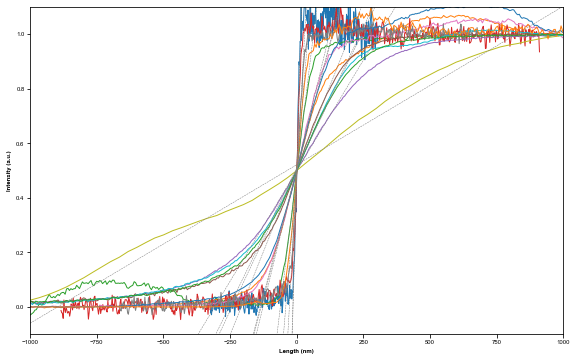

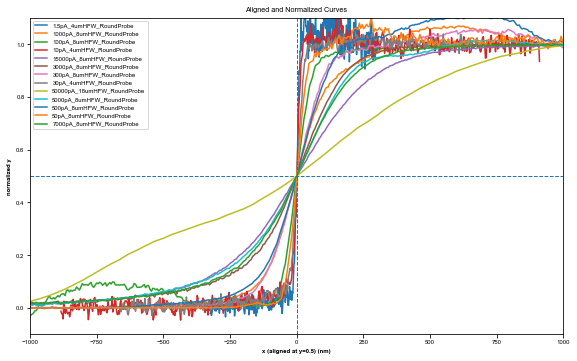

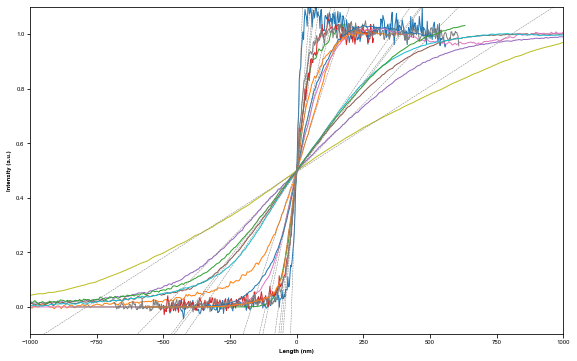

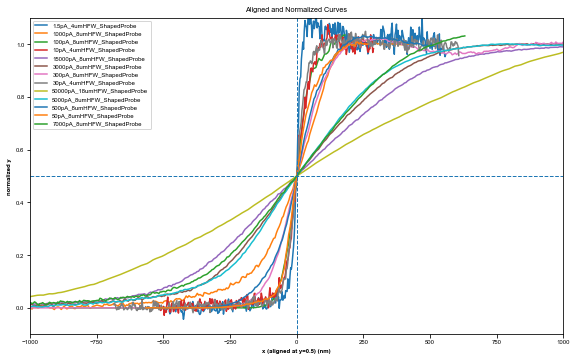

In [245]:
dataset_dirs = [
    r'\\samba-pool-plitzko3\pool-plitzko3\Johann\03-Data\06-FIB-SEM\250717_Revision_BeamShaping\roundProbe',
    r'\\samba-pool-plitzko3\pool-plitzko3\Johann\03-Data\06-FIB-SEM\250717_Revision_BeamShaping\shapedProbe'
]
combined_results_list = []
combined_fit_list = []
combined_curves_list = []

for d in dataset_dirs:
    data_dict, res_df, curves_df = process_all(d)
    # Label dataset
    res_df['dataset'] = os.path.basename(d)
    combined_results_list.append(res_df)

    # Fit around y=0.5
    fit_df = fit_wendepunkt(curves_df)
    fit_df['dataset'] = os.path.basename(d)
    combined_fit_list.append(fit_df)

    plot_fit_lines(curves_df, fit_df, xlim=(-1000, 1000), ylim=(-0.1, 1.1), figsize=(8,5))
    plot_curves(curves_df, xlim=(-1000, 1000), ylim=(-0.1, 1.1), figsize=(8,5))

    
    combined_curves_list.append(curves_df)

# Combine all results
combined_results = pd.concat(combined_results_list, ignore_index=True)
combined_fit = pd.concat(combined_fit_list, ignore_index=True)
combined_curves = pd.concat(combined_curves_list, ignore_index=True)

# Save and print metrics
combined_results.to_csv('combined_results.csv', index=False)
combined_fit.to_csv('combined_fits.csv', index=False)
#print(combined_results)


### Knife-Edge d<sub>50</sub> vs. beam current

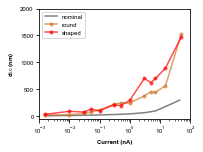

In [246]:
# Final plots
#plot_results(combined_results, nominal_sizes, scale='loglog', figsize=(4,3))
plot_results(combined_results, nominal_sizes, scale='semilogx', figsize=(4*0.7,3*0.7))

### Plot the results from fitted lines at y=0.5 evaluated a d50

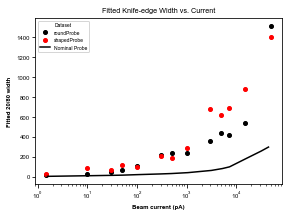

In [247]:
plot_fitted_results(combined_fit, nominal_sizes)

C:\Users\Johann\AppData\Local\Temp\ipykernel_9096\1351041378.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_curve['dataset'] = probe
C:\Users\Johann\AppData\Local\Temp\ipykernel_9096\1351041378.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Johann\AppData\Local\Temp\ipykernel_9096\1351041378.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Johann\AppData\Local\Temp\ipykernel_9096\1351041378.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

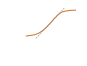

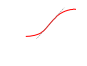

In [248]:
current = 300
probe = 'oundProbe'
for probe in ['oundProbe', 'hapedProbe']:
    filtered_curve = combined_curves[
        (combined_curves['current_pA'] == current) & 
        (combined_curves['name'].str.contains(probe))
        ]
    filtered_curve['dataset'] = probe
    filtered_fit = combined_fit[
        (combined_fit['current_pA'] == current) & 
        (combined_fit['dataset'].str.contains(probe))
        ]
    fig, ax = plot_fit_lines(filtered_curve, filtered_fit, xlim=(-251, 251), ylim=(-0.1, 1.1), figsize=(4*0.3,3*0.3)) 
    lines = ax.get_lines()
    if probe == 'oundProbe':
        if len(lines) >= 2:
            lines[0].set_color('#cf782c')    # Set first line to red
            lines[1].set_color('grey')   # Set second line to blue
    else:    
        if len(lines) >= 2:
            lines[0].set_color('r')    # Set first line to red
            lines[1].set_color('grey')   # Set second line to blue


        # Set tick color and label color to white
    ax.tick_params(axis='both', colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')

    # Set spine (border) colors to white
    for spine in ax.spines.values():
        spine.set_color('white')

    # Set title color to white (if used)
    ax.title.set_color('white')

    # Optional: change text objects to white
    for text in ax.texts:
        text.set_color('white')

    fig.tight_layout()    
    fig.show()
    if probe == 'oundProbe':
        fig.savefig('beamshaping_knife-edge_raw_data_fit_roundProbe_single.png',dpi=600)
        fig.savefig('beamshaping_knife-edge_raw_data_fit_roundProbe_single.pdf',dpi=600, bbox_inches='tight',transparent=True)
    
    else:       
        fig.savefig('beamshaping_knife-edge_raw_data_fit_shapedProbe_single.png',dpi=600)
        fig.savefig('beamshaping_knife-edge_raw_data_fit_shapedProbe_single.pdf',dpi=600, bbox_inches='tight',transparent=True)
    fig.show()
